In [1]:
import gzip

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt

# Preprocessing

## Meta data

In [2]:
def read_geo_series_matrix(file_path):
    cols = {}
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if line.startswith("!Sample_title"):
                sampleId = [i.strip('"') for i in line.split()[1:]]
                cols["sampleId"] = sampleId
            elif line.startswith("!Sample_characteristics_ch1"):
                _ = line[28:].strip().strip('"').split('"\t"')
                category = _[0].split(": ")[0].replace(" ", "_")
                values = [i.split(": ")[1] for i in _]
                cols.update({category: values})
    
    return pd.DataFrame(cols)

In [3]:
meta = read_geo_series_matrix("../rawData/GSE49711_series_matrix.txt.gz")
meta.index = meta.sampleId
meta.shape

(498, 11)

In [4]:
meta = meta.loc[meta.death_from_disease.isin(["0", "1"])]
meta = meta.loc[(meta.death_from_disease == "1") | ((meta.death_from_disease == "0") & (meta.progression == "0"))]
meta.shape

In [5]:
meta.death_from_disease.value_counts()

0    315
1    105
Name: death_from_disease, dtype: int64

In [6]:
pd.crosstab(meta.inss_stage, meta.death_from_disease)

death_from_disease,0,1
inss_stage,,
1,112,1
2,59,4
3,36,14
4,68,82
4S,40,4


In [7]:
pd.crosstab(meta.high_risk, meta.death_from_disease)

death_from_disease,0,1
high_risk,,
0,259,13
1,56,92


In [8]:
meta.Sex.replace({"M":1, "F":0}, inplace=True)
meta.replace({"N/A":np.nan}, inplace=True)

In [9]:
stage_dummy = pd.get_dummies(meta.inss_stage, prefix='inss_stage')
meta = pd.concat([meta, stage_dummy], axis=1)

In [10]:
meta = meta[["Sex", "age_at_diagnosis", "high_risk", 
               "death_from_disease"
              ]]

In [11]:
meta.dropna(inplace=True)

In [12]:
meta = meta.astype("double")

In [13]:
meta.head()

,Sex,age_at_diagnosis,high_risk,death_from_disease
sampleId,,,,
SEQC_NB001,1.0,987.0,1.0,1.0
SEQC_NB002,1.0,1808.0,1.0,1.0
SEQC_NB003,0.0,625.0,1.0,1.0
SEQC_NB004,0.0,335.0,1.0,0.0
SEQC_NB005,0.0,536.0,1.0,1.0


## Gene level

In [14]:
rna = pd.read_table("../rawData/GSE49711_SEQC_NB_TAV_G_log2.final.txt.gz")
rna = rna[~ rna.Gene.str.contains("[a-z]")]
rna.drop(["Gene_set","NCBI_gene_ID","RefSeq_transcript_ID","Chromosome","Strand","Start","End"], axis=1, inplace=True)
X = rna.iloc[:,1:].transpose()
X.columns = rna.Gene

In [15]:
X = X.loc[meta.index] # keep only samples with valid Ys

In [16]:
X_train, X_, y_train, y_ = train_test_split(X, meta.death_from_disease.astype("int"), test_size=0.3, random_state=1234)

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size = 0.5, random_state=1234)

# QC

<Axes: >

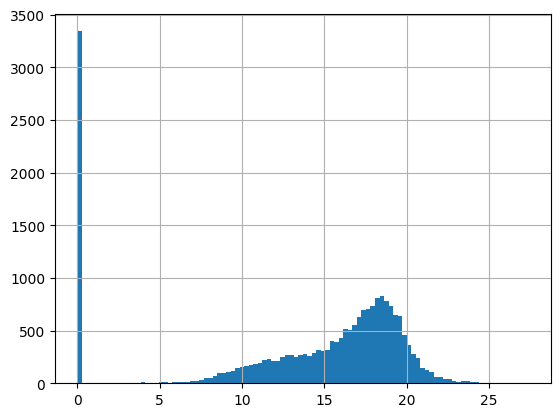

In [18]:
X_train.median().hist(bins=100)

In [19]:
X_train = X_train.loc[:, X_train.median() > 5]

In [20]:
X_train.shape

(294, 17694)

In [21]:
X_train

Gene,A1BGAS,A2BP1,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sampleId,,,,,,,,,,,,,,,,,,,,,
SEQC_NB040,16.9214,17.2464,14.1417,22.0852,11.7876,13.0336,17.1819,10.6736,19.9266,18.3365,...,18.1323,16.9260,14.9269,16.1530,18.4369,11.0879,19.6466,20.4251,19.4628,18.5454
SEQC_NB072,16.0839,20.2916,14.5879,20.9280,12.1853,10.3161,15.5437,9.0993,19.6639,17.8574,...,18.6598,18.5681,14.4482,16.0062,18.7155,8.7723,19.6248,19.7722,19.6033,18.7152
SEQC_NB488,15.4718,18.7533,14.1369,21.5085,0.0000,0.0000,15.4508,0.0000,19.7524,17.8885,...,19.1890,18.8260,15.1024,16.0536,18.2013,12.8781,18.7069,18.5950,18.0696,18.5557
SEQC_NB194,16.5012,17.5480,14.6940,20.9406,0.0000,11.6724,15.4061,0.0000,19.7109,18.6228,...,18.3684,19.4462,15.0912,16.4076,18.3678,10.2605,18.8465,19.7943,19.2193,18.4731
SEQC_NB482,16.2520,20.1890,15.3050,21.5943,12.1800,12.1682,15.6356,11.3361,20.2317,18.4132,...,18.4065,18.4758,14.6793,15.8586,18.8062,9.7608,19.3758,20.0152,19.4243,18.5972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB239,17.0500,20.2921,12.5961,20.5891,10.9143,11.6394,14.9071,11.2377,19.6256,17.4495,...,18.3647,17.2641,15.5657,16.5898,18.1298,9.1919,19.4643,19.8513,19.0780,18.8069
SEQC_NB056,16.2465,18.7481,14.5697,21.9174,9.7166,12.5243,16.1371,11.6464,19.8621,18.2074,...,18.6634,18.4127,14.7022,16.1277,18.6879,0.0000,19.8287,20.0065,19.6425,19.2073
SEQC_NB344,16.3053,19.5447,14.7848,20.4421,9.7949,11.1724,14.3122,10.5518,20.0238,17.9631,...,17.8767,17.3381,14.4554,15.4317,18.5616,8.6689,19.6524,20.0438,19.1407,18.5329


In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [23]:
X_val_scaled = scaler.transform(X_val.loc[:, X_train.columns])
X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_train.columns)

In [24]:
X_test_scaled = scaler.transform(X_test.loc[:, X_train.columns])
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_train.columns)

In [25]:
meta_train = meta.loc[X_train.index]
age_scaler = StandardScaler()
age_at_diagnosis = age_scaler.fit_transform(np.array(meta_train.age_at_diagnosis).reshape(-1, 1))
meta_train.age_at_diagnosis = age_at_diagnosis
meta_train.drop(["death_from_disease", "high_risk"], axis = 1, inplace=True)

In [26]:
X_train_scaled = pd.concat([X_train_scaled, meta_train], axis=1)

In [27]:
meta_val = meta.loc[X_val.index]
age_at_diagnosis = age_scaler.transform(np.array(meta_val.age_at_diagnosis).reshape(-1, 1))
meta_val.age_at_diagnosis = age_at_diagnosis
meta_val.drop(["death_from_disease", "high_risk"], axis = 1, inplace=True)

In [28]:
X_val_scaled = pd.concat([X_val_scaled, meta_val], axis=1)

In [29]:
meta_test = meta.loc[X_test.index]
age_at_diagnosis = age_scaler.transform(np.array(meta_test.age_at_diagnosis).reshape(-1, 1))
meta_test.age_at_diagnosis = age_at_diagnosis
meta_test.drop(["death_from_disease", "high_risk"], axis = 1, inplace=True)

In [30]:
X_test_scaled = pd.concat([X_test_scaled, meta_test], axis=1)

# L1 Logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report

In [32]:
model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv = 5, random_state=1234, Cs= 30, class_weight={0:1,1:100}, n_jobs= 4)
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=30, class_weight={0: 1, 1: 100}, cv=5, n_jobs=4,
                     penalty='l1', random_state=1234, solver='liblinear')

In [33]:
# Make predictions on the val set
y_pred = model.predict(X_val_scaled)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)

In [34]:
accuracy

0.8095238095238095

In [35]:
roc_auc_score(y_val, y_pred)

0.8666666666666667

In [36]:
pd.crosstab(y_pred, y_val)

death_from_disease,0,1
row_0,,
0,33,0
1,12,18


In [37]:
pd.crosstab(meta.loc[y_val.index].high_risk, meta.loc[y_val.index].death_from_disease)

death_from_disease,0.0,1.0
high_risk,,
0.0,33,3
1.0,12,15


In [38]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        45
           1       0.60      1.00      0.75        18

    accuracy                           0.81        63
   macro avg       0.80      0.87      0.80        63
weighted avg       0.89      0.81      0.82        63



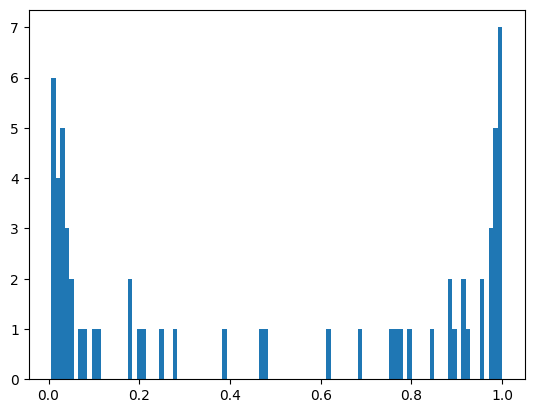

In [39]:
_ = plt.hist(model.predict_proba(X_val_scaled)[:,1], 100)

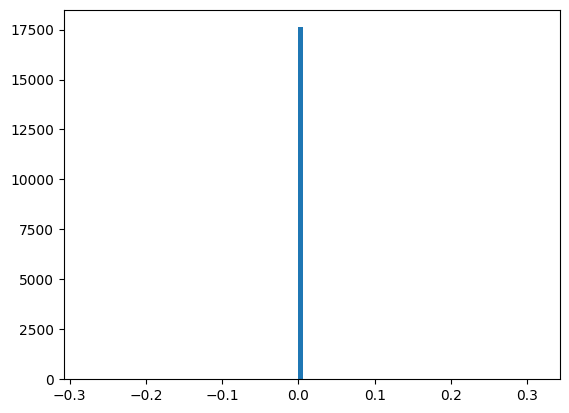

In [40]:
_ = plt.hist(model.coef_[0], 100)

In [41]:
sum(model.coef_[0] != 0)

88

In [42]:
indices = np.argsort(model.coef_[0])[::-1]

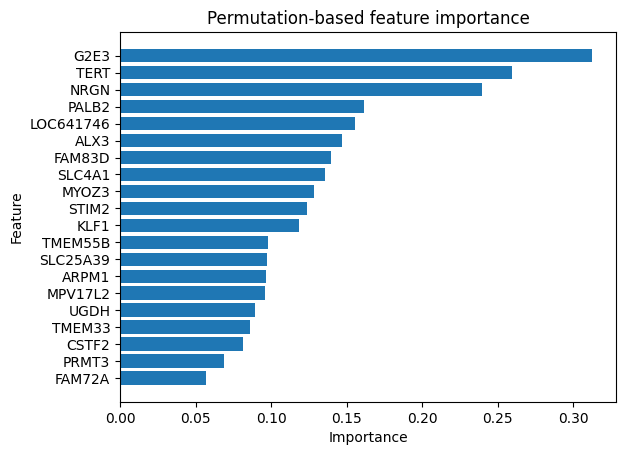

In [43]:
plt.barh(X_train_scaled.columns[indices][range(20)][::-1], model.coef_[0][indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

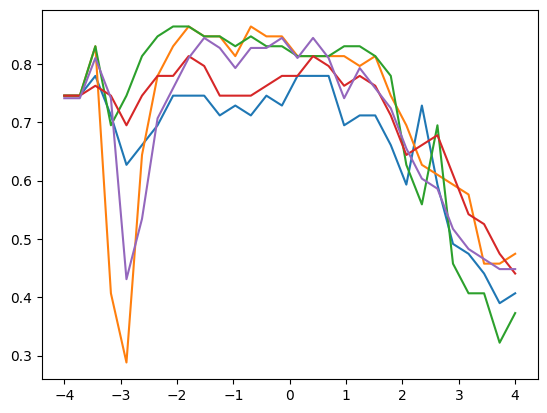

In [44]:
plt.plot(np.log10(model.Cs_), model.scores_[1].T)
plt.show()

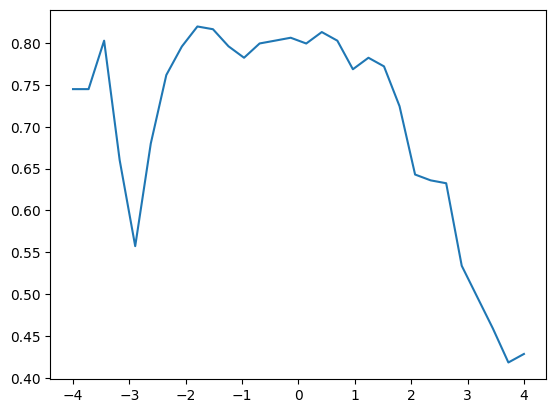

In [45]:
plt.plot(np.log10(model.Cs_), np.mean(model.scores_[1].T, axis = 1))
plt.show()

# Ranodm forest

In [46]:
from sklearn.ensemble import RandomForestClassifier


In [47]:
X_train = pd.concat([X_train, meta_train], axis=1)
X_val = pd.concat([X_val, meta_val], axis=1)
X_test = pd.concat([X_test, meta_test], axis = 1)

In [48]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=1234, class_weight={0:1, 1:100}, n_jobs=4)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 100}, n_estimators=1000, n_jobs=4,
                       random_state=1234)

In [49]:
y_pred = rf_classifier.predict(X_val.loc[:, X_train.columns])
accuracy = accuracy_score(y_val, y_pred)

In [50]:
accuracy

0.6507936507936508

In [51]:
roc_auc_score(y_val, y_pred)

0.5222222222222221

In [52]:
pd.crosstab(y_pred, y_val)

death_from_disease,0,1
row_0,,
0,37,14
1,8,4


In [53]:
pd.crosstab(meta.loc[y_val.index].high_risk, meta.loc[y_val.index].death_from_disease)

death_from_disease,0.0,1.0
high_risk,,
0.0,33,3
1.0,12,15


In [54]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.82      0.77        45
           1       0.33      0.22      0.27        18

    accuracy                           0.65        63
   macro avg       0.53      0.52      0.52        63
weighted avg       0.61      0.65      0.63        63



In [55]:
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

In [56]:
# Print the feature ranking
print("Feature ranking:")
for f in range(20):
    print("%d. %s: feature %d (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. PGM2L1: feature 11441 (0.010454)
2. PMP22: feature 11754 (0.006427)
3. SLC25A5P2: feature 14313 (0.006084)
4. SLC25A5: feature 14311 (0.005888)
5. TMEM191C: feature 15748 (0.005883)
6. PIRT: feature 11575 (0.005501)
7. PRMT5: feature 12121 (0.005366)
8. DDX39: feature 3135 (0.005323)
9. CAMTA1: feature 1571 (0.005311)
10. TMOD2: feature 15854 (0.005036)
11. LOC442777: feature 8483 (0.004608)
12. SSRP1: feature 14942 (0.004224)
13. VRK1: feature 16757 (0.003990)
14. UBL5: feature 16459 (0.003981)
15. MRPS18C: feature 9915 (0.003846)
16. LOC100286976: feature 7752 (0.003814)
17. PLXNA4: feature 11739 (0.003779)
18. PHLDB1: feature 11493 (0.003755)
19. MRPL11: feature 9862 (0.003720)
20. LOC100287215: feature 7772 (0.003700)


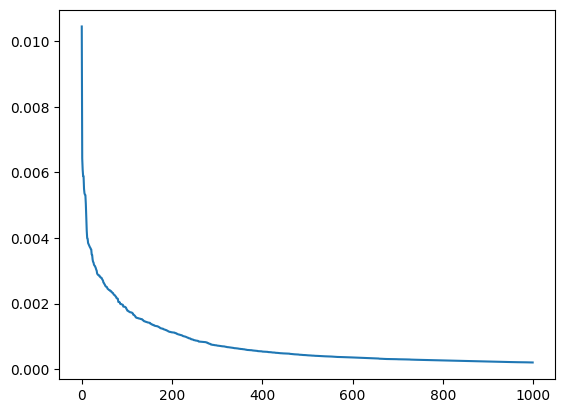

In [57]:
plt.plot(importances[indices][range(1000)])

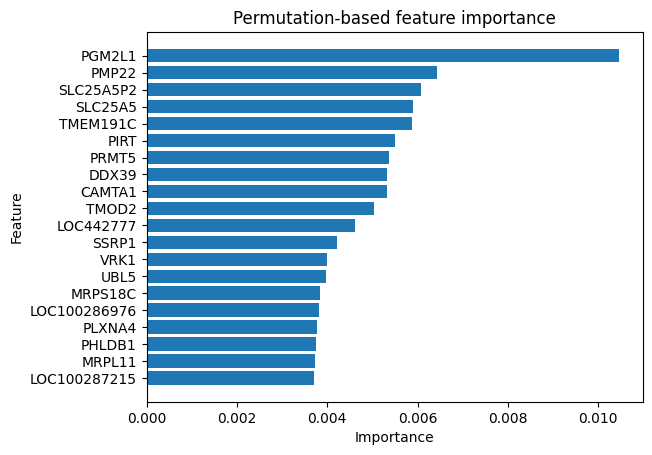

In [58]:
plt.barh(X_train.columns[indices][range(20)][::-1], importances[indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [64]:
from sklearn.metrics import f1_score


In [67]:
print("L1 test acc:", accuracy_score(y_test, model.predict(X_test_scaled)))
print("L1 test auc:", roc_auc_score(y_test, model.predict(X_test_scaled)))
print("L1 test f1:", f1_score(y_test, model.predict(X_test_scaled)))

L1 test acc: 0.8571428571428571
L1 test auc: 0.9117647058823529
L1 test f1: 0.7272727272727273


In [68]:
print("L1 val acc:", accuracy_score(y_val, model.predict(X_val_scaled)))
print("L1 val auc:", roc_auc_score(y_val, model.predict(X_val_scaled)))
print("L1 val f1:", f1_score(y_val, model.predict(X_val_scaled)))

L1 val acc: 0.8095238095238095
L1 val auc: 0.8666666666666667
L1 val f1: 0.7499999999999999


In [61]:
pd.crosstab(model.predict(X_test_scaled), y_test)

death_from_disease,0,1
row_0,,
0,42,0
1,9,12


In [69]:
print("RF test acc:", accuracy_score(y_test, rf_classifier.predict(X_test.loc[:, X_train.columns])))
print("RF test auc:", roc_auc_score(y_test, rf_classifier.predict(X_test.loc[:, X_train.columns])))
print("RF test f1:", f1_score(y_test, rf_classifier.predict(X_test.loc[:, X_train.columns])))

RF test acc: 0.8412698412698413
RF test auc: 0.678921568627451
RF test f1: 0.5


In [70]:
print("RF val acc:", accuracy_score(y_val, rf_classifier.predict(X_val.loc[:, X_train.columns])))
print("RF val auc:", roc_auc_score(y_val, rf_classifier.predict(X_val.loc[:, X_train.columns])))
print("RF val f1:", f1_score(y_val, rf_classifier.predict(X_val.loc[:, X_train.columns])))

RF val acc: 0.6507936507936508
RF val auc: 0.5222222222222221
RF val f1: 0.26666666666666666


In [63]:
pd.crosstab(rf_classifier.predict(X_test.loc[:, X_train.columns]), y_test)

death_from_disease,0,1
row_0,,
0,48,7
1,3,5


In [65]:
f1_score(y_test, model.predict(X_test_scaled))


0.7272727272727273

In [66]:
f1_score(y_test, rf_classifier.predict(X_test.loc[:, X_train.columns]))

0.5

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4290828/

In [71]:
# acc, auc, f1
lr_val_scores = [0.81, 0.87, 0.75]
lr_test_scores = [0.86, 0.91, 0.73]

rf_val_scores = [0.65, 0.52, 0.27]
rf_test_scores = [0.84, 0.68, 0.5]